In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint

In [3]:
def show(X):
	if X.dim() == 3 and X.size(0) == 3:
		plt.imshow( np.transpose(  X.numpy() , (1, 2, 0))  )
		plt.show()
	elif X.dim() == 2:
		plt.imshow(   X.numpy() , cmap='gray'  )
		plt.show()
	else:
		print('WRONG TENSOR SIZE')

In [4]:
import os.path
def check_fashion_mnist_dataset_exists(path_data='../../data/'):
    flag_train_data = os.path.isfile(path_data + 'fashion-mnist/train_data.pt') 
    flag_train_label = os.path.isfile(path_data + 'fashion-mnist/train_label.pt') 
    flag_test_data = os.path.isfile(path_data + 'fashion-mnist/test_data.pt') 
    flag_test_label = os.path.isfile(path_data + 'fashion-mnist/test_label.pt') 
    if flag_train_data==False or flag_train_label==False or flag_test_data==False or flag_test_label==False:
        print('FASHION-MNIST dataset missing - downloading...')
        import torchvision
        import torchvision.transforms as transforms
        trainset = torchvision.datasets.FashionMNIST(root=path_data + 'fashion-mnist/temp', train=True,
                                                download=True, transform=transforms.ToTensor())
        testset = torchvision.datasets.FashionMNIST(root=path_data + 'fashion-mnist/temp', train=False,
                                               download=True, transform=transforms.ToTensor())
        train_data=torch.Tensor(60000,28,28)
        train_label=torch.LongTensor(60000)
        for idx , example in enumerate(trainset):
            train_data[idx]=example[0].squeeze()
            train_label[idx]=example[1]
        torch.save(train_data,path_data + 'fashion-mnist/train_data.pt')
        torch.save(train_label,path_data + 'fashion-mnist/train_label.pt')
        test_data=torch.Tensor(10000,28,28)
        test_label=torch.LongTensor(10000)
        for idx , example in enumerate(testset):
            test_data[idx]=example[0].squeeze()
            test_label[idx]=example[1]
        torch.save(test_data,path_data + 'fashion-mnist/test_data.pt')
        torch.save(test_label,path_data + 'fashion-mnist/test_label.pt')
    return path_data

In [5]:
def show_prob_fashion_mnist(p):


	p=p.data.squeeze().numpy()

	ft=15
	label = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag','Boot')
	#p=p.data.squeeze().numpy()
	y_pos = np.arange(len(p))*1.2
	target=2
	width=0.9
	col= 'blue'
	#col='darkgreen'

	plt.rcdefaults()
	fig, ax = plt.subplots()

	# the plot
	ax.barh(y_pos, p, width , align='center', color=col)

	ax.set_xlim([0, 1.3])
	#ax.set_ylim([-0.8, len(p)*1.2-1+0.8])

	# y label
	ax.set_yticks(y_pos)
	ax.set_yticklabels(label, fontsize=ft)
	ax.invert_yaxis()  
	#ax.set_xlabel('Performance')
	#ax.set_title('How fast do you want to go today?')

	# x label
	ax.set_xticklabels([])
	ax.set_xticks([])
	#x_pos=np.array([0, 0.25 , 0.5 , 0.75 , 1])
	#ax.set_xticks(x_pos)
	#ax.set_xticklabels( [0, 0.25 , 0.5 , 0.75 , 1] , fontsize=15)

	ax.spines['right'].set_visible(False)
	ax.spines['top'].set_visible(False)
	ax.spines['bottom'].set_visible(False)
	ax.spines['left'].set_linewidth(4)


	for i in range(len(p)):
	    str_nb="{0:.2f}".format(p[i])
	    ax.text( p[i] + 0.05 , y_pos[i] ,str_nb ,
	             horizontalalignment='left', verticalalignment='center',
	             transform=ax.transData, color= col,fontsize=ft)



	plt.show()
	#fig.savefig('pic/prob', dpi=96, bbox_inches="tight")


Download the data and print the sizes

In [6]:
data_path=check_fashion_mnist_dataset_exists()
train_data=torch.load(data_path+'fashion-mnist/train_data.pt')

print(train_data.size())

train_label=torch.load(data_path+'fashion-mnist/train_label.pt')

print(train_label.size())

test_data=torch.load(data_path+'fashion-mnist/test_data.pt')

print(test_data.size())

FASHION-MNIST dataset missing - downloading...



Extracting ../../data/fashion-mnist/temp/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../../data/fashion-mnist/temp/FashionMNIST/raw




Extracting ../../data/fashion-mnist/temp/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../../data/fashion-mnist/temp/FashionMNIST/raw




Extracting ../../data/fashion-mnist/temp/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/fashion-mnist/temp/FashionMNIST/raw




Extracting ../../data/fashion-mnist/temp/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/fashion-mnist/temp/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])


Make a ONE layer net class. The network output are the scores! No softmax needed! You have only one line to write in the forward function

In [7]:
class one_layer_net(nn.Module):

    def __init__(self, input_size, output_size):
        super(one_layer_net , self).__init__()
        self.linear_layer = nn.Linear( input_size, output_size , bias=False)
        
    def forward(self, x):
        scores = self.linear_layer(x)
        return scores

Build the net

In [8]:
net=one_layer_net(28*28,10)
print(net)

one_layer_net(
  (linear_layer): Linear(in_features=784, out_features=10, bias=False)
)


Choose the criterion, optimizer. Set the batchize and learning rate to be:
batchize = 50
learning rate = 0.01

In [10]:
criterion = nn.CrossEntropyLoss()

optimizer=torch.optim.SGD( net.parameters() , lr=0.01 )

bs=50

Complete the training loop

In [11]:
for iter in range(1,5000):
    
    # Set dL/dU, dL/dV, dL/dW to be filled with zeros
    optimizer.zero_grad()
     
    # create a minibatch
    indices=torch.LongTensor(bs).random_(0,60000)
    minibatch_data =  train_data[indices]
    minibatch_label= train_label[indices]
    
    #reshape the minibatch
    inputs = minibatch_data.view(bs,28*28)
    
    # tell Pytorch to start tracking all operations that will be done on "inputs"
    inputs.requires_grad_()

    # forward the minibatch through the net  
    scores=net( inputs ) 
    
    # Compute the average of the losses of the data points in the minibatch
    loss = criterion( scores , minibatch_label) 
    
    # backward pass to compute dL/dU, dL/dV and dL/dW    
    loss.backward()
    
    # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
    optimizer.step()

Choose image at random from the test set and see how good/bad are the predictions

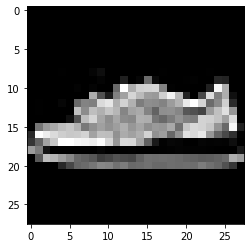

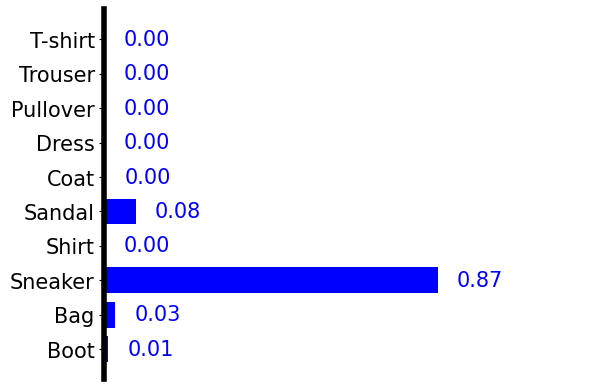

In [12]:
# choose a picture at random
idx=randint(0, 10000-1)
im=test_data[idx]

# diplay the picture
show(im)

# feed it to the net and display the confidence scores
scores =  net( im.view(1,784)) 
probs= F.softmax(scores, dim=1)
show_prob_fashion_mnist(probs)